# ISC data analysis

In [209]:
import sys
#import obspy
#from obspy.imaging.beachball import beachball, beach
from mpl_toolkits.basemap import Basemap
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import PIL
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from dateutil import parser
from datetime import datetime, timezone

#from obspy import read_inventory, read_events
import pandas as pd

%matplotlib inline

In [3]:
def rm_wspace_header(data):
    
    data.columns = data.columns.str.replace(' ', '')
    
    return data

def rm_wspace_column(data, col_name):
    
    data[col_name] = data[col_name].str.replace(' ', '')
    
    return data

def sel_by_priority(data, col_grp, col_want, col_sel, prio_list, keep = 'first'):
    
    """
    data - dataframe containing data to process
    col_grp - name of the column to use for iterating and grouping similar values (e.g. EVENT_ID) # one val
    col_want - name of column containing the value that you can't live without - for now handles numerical values
    col_sel - name of the column to use for judging priority 
    prio_list - priority list of col_sel values - top to least # in list format
    keep - in case an event has multiple entries by the same author, drop the duplicates (keep can be 'first', 'last', False)
        - for more info, read about pandas.DataFrame.drop_duplicates
    """
    
    unique_events = pd.unique(data[col_grp])
    print('Unique events detected: ', unique_events.shape[0])
    
    grp = data.groupby(col_grp)
    #dev_count = 0
    for ev_id in unique_events:
        #print(ev_id)
        to_filt = grp.get_group(ev_id) # get rows to use in filtering
        
#         if len(to_filt) == 1:
#             # check if the quantity we are interested in is here
#             #if np.asarray(to_filt[col_sel]) != prio_list[0]:
#             #    dev_count += 1
#             if str(to_filt[col_want]).isspace(): # remove since it is blank
#                 data = data.drop(index = to_filt.index)
#             # else go to another ev_id
#         else: # more than 1
        found_flag = False
        idx = np.asarray(to_filt.index)
        for prio in prio_list:
            a = np.asarray(to_filt[col_sel]) == prio # get values that are true
            #print('sum', a.sum())
            if a.sum() > 0: # found prio 
                # check if quantity of interest is present
                quant_val = to_filt[to_filt[col_sel] == prio]
                #print('here', idx)
                # if quantity of interest is present then drop columns and break
                if not np.asarray(quant_val[col_want])[0].isspace():
                    a = ~a
                    to_rm = idx[a]
                    #print("Removing indices: ", to_rm)
                    data = data.drop(index = to_rm)
                    found_flag = True
                    break

        if not found_flag: # if none are in the prio_list, then remove all
            #print('None found. Deleting. ')
            data = data.drop(index = idx)
                
    #print('Deviation count:', dev_count)
    #drop_duplicates(self, subset=None, keep='first', inplace=False)[source]
    data.drop_duplicates(subset = [col_grp], keep = keep, inplace = True)                   
    return data

def sep_norm_thrust_by_hauksson(data, rake_col1, rake_col2):

    # Haukkson (1990) scheme for classifying events
    # also used by USGS
    # normal - rake: -45 to -135 deg
    # thrust - rake: 45 to 135 deg
    # strike-slip: 44 to -44 deg or 136 to -136 deg

    self.opposite_rake = (self.np1[:, 2] > 0) & (self.np2[:, 2] < 0)
    self.opposite_rake = (self.opposite_rake) | (self.np1[:, 2] < 0) & (self.np2[:, 2] > 0)

    #self.normal_idx = (self.np1[:, 2] < -45) & (self.np1[:, 2] > -135) & (self.np2[:, 2] < -45) & (self.np2[:, 2] > -135)
    #self.thrust_idx = (self.np1[:, 2] > 45) & (self.np1[:, 2] < 135) & (self.np2[:, 2] > 45) & (self.np2[:, 2] < 135)

    self.normal_idx = (self.np1[:, 2] < -45) & (self.np1[:, 2] > -135)
    self.thrust_idx = (self.np1[:, 2] > 45) & (self.np1[:, 2] < 135)

    self.normal_idx = np.where(self.normal_idx)[0]
    self.thrust_idx = np.where(self.thrust_idx)[0]


    return

## Data processing starts here

In [7]:
fname = '/Users/jgra0019/Documents/phd_data/focal_meca/ISC_data/1976_2019_more_5.csv'
isc_data = pd.read_csv(fname, comment = "#", sep = ',', header = 'infer')
isc_data = rm_wspace_header(isc_data)

In [8]:
isc_data = rm_wspace_column(isc_data, 'AUTHOR')

prio_list = ['GCMT', 'HRVD', 'ISC', 'NEIS', 'NEIC', 'MOS', 'NIED']
filtered_data = sel_by_priority(isc_data, 'EVENT_ID', 'MO', 'AUTHOR', prio_list)

filtered_data = filtered_data.drop(['AUTHOR.1', 'CENTROID'], axis=1)
sorted_df = filtered_data.sort_values(by = 'MW',ascending=False)

Unique events detected:  2575


# Save the filtered data
and then read it again. Having problems with datatypes.

In [9]:
fname = '/Users/jgra0019/Documents/phd_data/focal_meca/ISC_data/filt_1976_2019_more_5.csv'
sorted_df.to_csv(fname)
sorted_df = pd.read_csv(fname, sep = ',', header = 'infer')

# Separate into thrust and normal earthquakes
Using the rake. For more info, see Haukkson (1992?)

In [80]:
thrust_df = sorted_df[(sorted_df['RAKE'] >= 45) & (sorted_df['RAKE'] <= 135)]

classif_col = ['LON', 'LAT', 'DEPTH', 'DATE', 'TIME', 'EVENT_ID', 'AUTHOR', 'EX', 'MO', 'MW']
thrust_df = thrust_df[classif_col]
thrust_df

LON    LAT  DEPTH        DATE         TIME   EVENT_ID AUTHOR  EX  \
0      94.26   3.09   28.6  2004-12-26  00:58:50.00    7453151   HRVD  22   
2      97.07   1.67   25.8  2005-03-28  16:09:36.50    7486110   HRVD  22   
3     100.99  -3.78   24.4  2007-09-12  11:10:26.80   13203322   GCMT  21   
6     100.13  -2.46   43.1  2007-09-12  23:49:03.70   13203366   GCMT  20   
7     119.93   0.74   15.0  1996-01-01  08:05:23.10     939295   HRVD  20   
...      ...    ...    ...         ...          ...        ...    ...  ..   
2553  112.57  -8.99   74.1  2016-03-02  06:09:11.90  611838940   GCMT  16   
2555   96.19   1.96   36.2  2016-04-20  20:44:39.70  608588070   GCMT  16   
2556   92.96   4.65   12.0  2006-04-05  18:35:11.80    8228819   HRVD  16   
2559  117.95 -10.12   42.3  2014-02-23  21:21:18.40  604061530   GCMT  16   
2562  105.86  -7.56   38.4  2010-02-20  04:57:34.20   14319033   GCMT  16   

         MO   MW  
0     3.950  9.0  
2     1.050  8.6  
3     6.711  8.5  
6     8.133  7.9  
7     7.780  7.9  
...     ...  ...  
2553  2.938  4.9  
2555  2.791  4.9  
2556  3.324  4.9  
2559  2.739  4.9  
2562  3.299  4.9  

[1161 rows x 10 columns]

In [81]:
fname = '/Users/jgra0019/Documents/phd_data/focal_meca/ISC_data/thrust_to_classif.csv'
thrust_df.to_csv(fname, index = False, header = None)

In [82]:
normal_df = sorted_df[(sorted_df['RAKE'] <= -45) & (sorted_df['RAKE'] >= -135)]
normal_df = normal_df[classif_col]

fname = '/Users/jgra0019/Documents/phd_data/focal_meca/ISC_data/norm_to_classif.csv'

normal_df.to_csv(fname, index = False, header = None)

In [149]:
ss_cond = (np.abs(sorted_df['RAKE']) <= 44) | (np.abs(sorted_df['RAKE']) >= 136) 
ss_df = sorted_df[ss_cond]
#ss_df

# Analyze seismicity along trench

In [487]:
# seismicity along trench and slab length

event_type = 'thrust'

step = '50km_step'
output_dir = '/Users/jgra0019/Documents/codes/focal_meca/plots/' + step
if event_type == 'normal':
    eq_fname_top = '/Users/jgra0019/Documents/codes/focal_meca/output/' + step +'/top_half/normal_collated.csv'
    eq_fname_low = '/Users/jgra0019/Documents/codes/focal_meca/output/' + step +'/low_half/normal_collated.csv'
    prefix = step + '_normal'
    title = 'Normal earthquakes along trench (1976 - 2018)'
elif event_type == 'thrust':
    eq_fname_top = '/Users/jgra0019/Documents/codes/focal_meca/output/' + step +'/top_half/thrust_collated.csv'
    eq_fname_low = '/Users/jgra0019/Documents/codes/focal_meca/output/' + step +'/low_half/thrust_collated.csv'
    prefix = step + '_thrust'
    title = 'Thrust earthquakes along trench (1976 - 2018)'
    
#slab_fname1 = '/Users/jgra0019/Documents/codes/focal_meca/gmt_codes/aux_files/slab_length_50km.csv'
# stick to 100 km 
slab_fname_top = '/Users/jgra0019/Documents/codes/focal_meca/output/100km_step/top_half/top_slab_length.csv'
slab_fname_low = '/Users/jgra0019/Documents/codes/focal_meca/output/100km_step/low_half/low_slab_length.csv'

df_top = pd.read_csv(eq_fname_top, sep = ',', header = None)
df_low = pd.read_csv(eq_fname_low, sep = ',', header = None)
slab_length_top = pd.read_csv(slab_fname_top, sep = ',', header = 'infer')
slab_length_low = pd.read_csv(slab_fname_low, sep = ',', header = 'infer')
#slab_length1 = pd.read_csv(slab_fname1, sep = ',', header = 'infer')

#length1 = length[1:]
#length2 = length[0:-1]
#length_der = (length1 - length2)/100
 
df_top[15] = -df_top[15] # assign top as having negative distance along trench
df = df_top.append(df_low, ignore_index=True)

slab_length_top['Along'] = -slab_length_top['Along']
slab_length=slab_length_top.append(slab_length_low, ignore_index=True)
slab_length = slab_length.sort_values(by = 'Along',ascending=True)
length = np.asarray(slab_length['Slab length'])
#print(df_top.shape)
#print(df_low.shape)
df.drop_duplicates(subset = [6], keep = 'first', inplace = True)  
df.shape

(1111, 17)

In [489]:
fig, ax1 = plt.subplots(dpi = 300)

plt.title(title)
color = 'tab:gray'
ax1.set_xlabel('distance along trench [km]')
ax1.set_ylabel(r'years before 2004 $M_w\ 9.0$ event', color=color)  # we already handled the x-label with ax1
plot = ax1.scatter(df[15], df[16], s = df[10]**2.1, linewidth = 0.5, edgecolors = 'k', alpha = 0.4, c = color)
#cbar = plt.colorbar(plot, orientation = 'horizontal')#, pad = 0.15)
#cbar.ax.get_yaxis().labelpad = 15
#cbar.ax.tick_params(axis='x',direction='in',labeltop='on')
#cbar.ax.set_xlabel('Depth (km)', fontsize = 8)

ax1.plot([along_2004 - 1300, along_2004], [0, 0], 'o-', linewidth = 2, color = 'y')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('slab length [km]', color=color)
ax2.plot(slab_length['Along'], slab_length['Slab length'], 'o-', color=color, alpha = 0.9, markersize = 2.5, linewidth = 1)
#ax2.plot(slab_length1['Along'], slab_length1['Slab length'], 'o-', color='g', alpha = 0.9, markersize = 2.5, linewidth = 1)
ax2.tick_params(axis='y', labelcolor=color)
#ax2.set_ylim([-30, 20])
#ax2.set_xlim([-200 - 3550, 6300 - 3550])

ax2.text(-2750, 650, r'2004 M_w 9.0 event', color = 'y', weight='bold')
#ax2.vlines(3550, 200, 900)


fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig(output_dir + '/'+prefix+'_time_vs_trench.png', dpi = 300)
#ax2.

In [490]:
zero_df = df[df[15] == 0]
zero_df = zero_df[[1, 2, 3, 6, 7, 8, 9, 10, 15, 16]]
zero_df = zero_df.rename(columns = {1:'LON', 2:'LAT', 3:'DEPTH', 6:'EVENT_ID', 7:'AUTHOR', 8:'EXP', 9:'MO', 10:'MW', 15:'ALONG', 16:'TIME'})

shallow_slab_df = df[df[15] < 0]
shallow_slab_df = shallow_slab_df[[1, 2, 3, 6, 7, 8, 9, 10, 15, 16]]
shallow_slab_df = shallow_slab_df.rename(columns = {1:'LON', 2:'LAT', 3:'DEPTH', 6:'EVENT_ID', 7:'AUTHOR', 8:'EXP', 9:'MO', 10:'MW', 15:'ALONG', 16:'TIME'})

deep_slab_df = df[df[15] > 0]
deep_slab_df = deep_slab_df[[1, 2, 3, 6, 7, 8, 9, 10, 15, 16]]
deep_slab_df = deep_slab_df.rename(columns = {1:'LON', 2:'LAT', 3:'DEPTH', 6:'EVENT_ID', 7:'AUTHOR', 8:'EXP', 9:'MO', 10:'MW', 15:'ALONG', 16:'TIME'})

# Analysis 1 
Plot the cumulative seismic moment released in the shallow and deep part


In [491]:
zero_df = zero_df.sort_values(by ='TIME', ascending=True)
shallow_slab_df = shallow_slab_df.sort_values(by ='TIME', ascending=True)
deep_slab_df = deep_slab_df.sort_values(by = 'TIME',ascending=True)

In [492]:
ze_exp = np.asarray(zero_df['EXP'])
ze_mo = np.asarray(zero_df['MO'])
ze_time = np.asarray(zero_df['TIME'])
ze_energy = ze_mo*np.power(10., ze_exp)
ze_sq = np.sqrt(ze_energy)
ze_strain_cum = np.cumsum(ze_sq)
ze_energy_cum = np.cumsum(ze_energy)


sh_exp = np.asarray(shallow_slab_df['EXP'])
sh_mo = np.asarray(shallow_slab_df['MO'])
sh_time = np.asarray(shallow_slab_df['TIME'])
sh_energy = sh_mo*np.power(10., sh_exp)
sh_energy_cum = np.cumsum(sh_energy)
sh_sq = np.sqrt(sh_energy)
sh_strain_cum = np.cumsum(sh_sq)

dp_exp = np.asarray(deep_slab_df['EXP'])
dp_mo = np.asarray(deep_slab_df['MO'])
dp_time = np.asarray(deep_slab_df['TIME'])
dp_energy = dp_mo*np.power(10., dp_exp)
dp_energy_cum = np.cumsum(dp_energy)
dp_sq = np.sqrt(dp_energy)
dp_strain_cum = np.cumsum(dp_sq)

In [496]:
# plot total seismic moment for each side
    
fig = plt.figure(dpi = 300)

# plt.plot(dp_time, dp_energy_cum, 'o-', markersize = 4, label = 'Long slab', mfc = 'white', mew = 0.8, lw = 0.8)
# plt.plot(sh_time, sh_energy_cum, 'o-', markersize = 4, label = 'Short slab', mfc = 'white', mew = 0.8, lw = 0.8)
# plt.plot(ze_time, ze_energy_cum, 'o-', markersize = 4, label = 'Origin', mfc = 'white', mew = 0.8, lw = 0.8)
plt.plot(dp_time, dp_strain_cum, 'o-', markersize = 4, label = 'Long slab', mfc = 'white', mew = 0.8, lw = 0.8)
plt.plot(sh_time, sh_strain_cum, 'o-', markersize = 4, label = 'Short slab', mfc = 'white', mew = 0.8, lw = 0.8)
plt.plot(ze_time, ze_strain_cum, 'o-', markersize = 4, label = 'Origin', mfc = 'white', mew = 0.8, lw = 0.8)
#plt.yscale('log')
plt.legend()
plt.xlabel(r'years before 2004 $M_w 9.0$ event')
plt.ylabel(r'$\Sigma M_o$')
#plt.ylabel(r'$M_o$')
plt.title(title)
#plt.set_xlim([-200, 6500])
#plt.ylim([2e16, 1e23])
#plt.savefig(output_dir + '/ISC_100km_time_vs_trench.png', dpi = 300)
plt.savefig(output_dir + '/'+prefix+'_total_mo_vs_time.png', dpi = 300)

In [482]:
# generate plots that look like pin heads
    
fig = plt.figure(dpi = 300)
plt.bar(dp_time, dp_energy, linewidth = 0.1, width = 0.05, alpha = 0.5)
plt.plot(dp_time, dp_energy, 'o', markersize = 4, label = 'Long slab', markerfacecolor = 'white')
plt.bar(sh_time, sh_energy, linewidth = 0.1, width = 0.05, alpha = 0.5)
plt.plot(sh_time, sh_energy, 'o', markersize = 4, label = 'Short slab', markerfacecolor = 'white')
plt.bar(ze_time, ze_energy, linewidth = 0.1, width = 0.05, alpha = 0.5)
plt.plot(ze_time, ze_energy, 'o', markersize = 4, label = 'Origin', markerfacecolor = 'white')
plt.yscale('log')
plt.legend()
plt.xlabel(r'years before 2004 $M_w 9.0$ event')
plt.ylabel(r'$M_o$')
#plt.ylabel(r'$M_o$')
plt.title(title)
#plt.set_xlim([-200, 6500])
#plt.ylim([1e16, 1e23])
plt.ylim()
plt.savefig(output_dir + '/'+prefix+'_mo_vs_time.png', dpi = 300)

# Analysis 2 
Plot the cumulative seismic moment released along the trench


In [483]:
# shallow part processing
#{1:'LON', 2:'LAT', 3:'DEPTH', 6:'EVENT_ID', 7:'AUTHOR', 8:'EXP', 9:'MO', 10:'MW', 15:'ALONG', 16:'TIME'})
shallow_slab_df = shallow_slab_df.sort_values(by = 'ALONG',ascending=True)
sh_along_pos = pd.unique(shallow_slab_df['ALONG'])
sh_along_energy = []

grp = shallow_slab_df.groupby('ALONG')

for pos in sh_along_pos:
        #print(ev_id)
    to_proc = grp.get_group(pos) 
    exp = np.asarray(to_proc['EXP'])
    mo = np.asarray(to_proc['MO'])
    mo = np.asarray(to_proc['MW'])
    #print(mo.max())
    #if mo.max() == 9.0:
    #    print(to_proc)
    energy = mo*np.power(10., exp)
    sh_along_energy.append(np.sum(energy))
    
sh_along_energy = np.asarray(sh_along_energy)

In [484]:
# origin part processing
#{1:'LON', 2:'LAT', 3:'DEPTH', 6:'EVENT_ID', 7:'AUTHOR', 8:'EXP', 9:'MO', 10:'MW', 15:'ALONG', 16:'TIME'})
zero_df = zero_df.sort_values(by = 'ALONG',ascending=True)
zero_along_pos = pd.unique(zero_df['ALONG'])
zero_along_energy = []

grp = zero_df.groupby('ALONG')

for pos in zero_along_pos:
        #print(ev_id)
    to_proc = grp.get_group(pos) 
    exp = np.asarray(to_proc['EXP'])
    mo = np.asarray(to_proc['MO'])
    mo = np.asarray(to_proc['MW'])
    #print(mo.max())
    #if mo.max() == 9.0:
    #    print(to_proc)
    energy = mo*np.power(10., exp)
    zero_along_energy.append(np.sum(energy))
    
zero_along_energy = np.asarray(zero_along_energy)
zero_along_energy

array([7.894e+18])

In [485]:
# deep part processing
deep_slab_df = deep_slab_df.sort_values(by = 'ALONG',ascending=True)
dp_along_pos = pd.unique(deep_slab_df['ALONG'])
dp_along_energy = []

grp = deep_slab_df.groupby('ALONG')

for pos in dp_along_pos:
    to_proc = grp.get_group(pos) 
    exp = np.asarray(to_proc['EXP'])
    mo = np.asarray(to_proc['MO'])
    energy = mo*np.power(10., exp)
    dp_along_energy.append(np.sum(energy))
    
dp_along_energy = np.asarray(dp_along_energy)

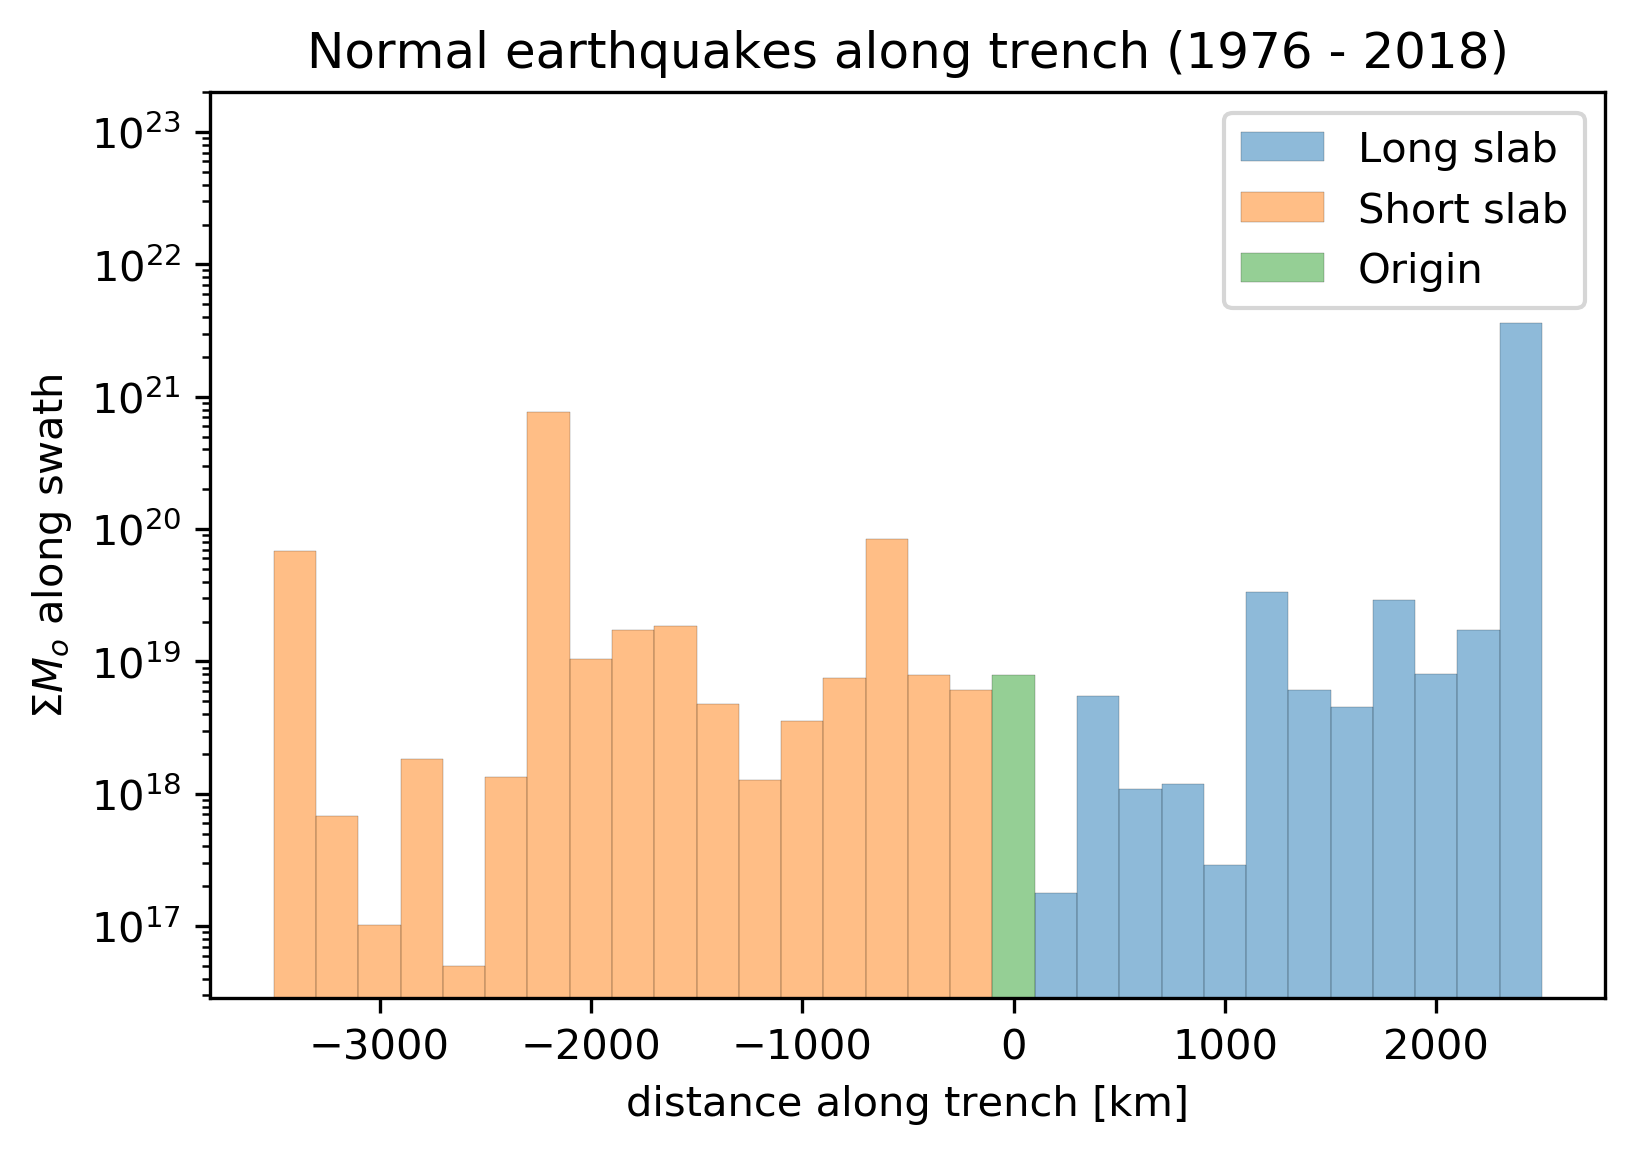

In [486]:
fig = plt.figure(dpi = 300)

width = 200
#plt.plot(dp_along_pos, dp_along_energy, 'o-', linewidth = 0.5, markersize = 2, fillstyle = 'none', label = 'Deep portion')
plt.bar(dp_along_pos, dp_along_energy, linewidth = 0.1, edgecolor = 'k', width = width, alpha = 0.5, label = 'Long slab')
plt.bar(sh_along_pos, sh_along_energy, linewidth = 0.1, edgecolor = 'k', width = width, alpha = 0.5, label = 'Short slab')
plt.bar(zero_along_pos, zero_along_energy, linewidth = 0.1, edgecolor = 'k', width = width, alpha = 0.5, label = 'Origin')
#plt.plot(sh_along_pos, sh_along_energy, 'o-', linewidth = 0.5, markersize = 2, fillstyle = 'none', label = 'Shallow portion')
plt.yscale('log')
plt.legend()
plt.xlabel('distance along trench [km]')
#plt.ylabel(r'$\Sigma M_o$')
plt.ylabel(r'$\Sigma$$M_o$ along swath')
plt.title(title)
#plt.xlim([-200, 6300])
plt.ylim(top = 2e23)
#plt.ylim([2e16, 1e22])
plt.savefig(output_dir + '/'+prefix+'_total_mo_vs_trench.png', dpi = 300)